In [1]:
# !pip install PyPortfolioOpt

In [2]:
# 필요한 라이브러리들을 불러옵니다.
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 포트폴리오 최적화를 위한 PyPortfolioOpt 라이브러리
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting

# 데이터프레임 출력 옵션 설정
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# --- 설정값 ---
INPUT_FILENAME = "top_50_zscore_rank_3Y.csv"
# ---

try:
    top_50_df = pd.read_csv(INPUT_FILENAME)
    tickers = top_50_df['Ticker'].tolist()
    tickers = list(set(tickers))

    print(f"✅ '{INPUT_FILENAME}'에서 상위 {len(tickers)}개 티커를 불러왔습니다.")
    print(tickers)
except FileNotFoundError:
    print(f"❌ 오류: '{INPUT_FILENAME}' 파일을 찾을 수 없습니다. 이전 단계를 먼저 실행해주세요.")
    tickers = []



✅ 'top_50_zscore_rank_3Y.csv'에서 상위 50개 티커를 불러왔습니다.
['NPCE', 'CLX', 'CRDO', 'MSTR', 'POWL', 'CVNA', 'WULF', 'NGL', 'KTOS', 'CELC', 'UAMY', 'FTAI', 'IESC', 'KINS', 'TSSI', 'PTGX', 'INOD', 'SMMT', 'HOOD', 'IREN', 'INSM', 'BKD', 'IDCC', 'SKYX', 'CIFR', 'DAVE', 'GGAL', 'RKLB', 'APLD', 'CDTX', 'CRS', 'RGTI', 'MAMA', 'AGX', 'ACIC', 'TPC', 'APP', 'PSIX', 'CLS', 'HRTG', 'MAS', 'PLTR', 'VRT', 'ROOT', 'STRL', 'AAOI', 'CRVS', 'BWAY', 'SLNO', 'PPTA']


In [3]:
# if tickers:
#     # 데이터 수집 기간 설정 (오늘부터 3년 전까지)
#     end_date = datetime.today()
#     start_date = end_date - timedelta(days=3*365)
    
#     print(f"\n✅ 데이터 수집 기간: {start_date.strftime('%Y-%m-%d')} ~ {end_date.strftime('%Y-%m-%d')}")
    
#     # yfinance를 통해 50개 종목의 수정 종가 데이터를 다운로드합니다.
#     prices = yf.download(tickers, start=start_date, end=end_date)['Adj Close'].dropna(how="all")
#     print("\n✅ 주가 데이터 수집 완료!")
#     display(prices.head())

In [4]:
if tickers:
    # 데이터 수집 기간 설정
    end_date = datetime.today()
    start_date = end_date - timedelta(days=3*365)
    
    print(f"\n✅ 데이터 수집 기간: {start_date.strftime('%Y-%m-%d')} ~ {end_date.strftime('%Y-%m-%d')}")
    
    # yfinance를 통해 전체 데이터를 다운로드합니다.
    # 최신 버전에서는 auto_adjust=True가 기본값이므로 'Adj Close'가 아닌 'Close'를 사용합니다.
    data = yf.download(tickers, start=start_date, end=end_date)
    
    # 'Close' 컬럼만 선택합니다. (이것이 이제 수정 종가입니다)
    if isinstance(data.columns, pd.MultiIndex):
        prices = data['Close'] # 이 부분을 수정
    else:
        prices = data[['Close']] # 이 부분도 수정

    prices = prices.dropna(how="all")
    
    print("\n✅ 주가 데이터 수집 완료!")
    display(prices.head())




✅ 데이터 수집 기간: 2022-11-23 ~ 2025-11-22


/tmp/ipykernel_476614/3381222765.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  50 of 50 completed



✅ 주가 데이터 수집 완료!


Ticker,AAOI,ACIC,AGX,APLD,APP,BKD,BWAY,CDTX,CELC,CIFR,CLS,CLX,CRDO,CRS,CRVS,CVNA,DAVE,FTAI,GGAL,HOOD,HRTG,IDCC,IESC,INOD,INSM,IREN,KINS,KTOS,MAMA,MAS,MSTR,NGL,NPCE,PLTR,POWL,PPTA,PSIX,PTGX,RGTI,RKLB,ROOT,SKYX,SLNO,SMMT,STRL,TPC,TSSI,UAMY,VRT,WULF
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-11-23,2.18,0.298484,35.443424,2.24,14.10,3.20,1.990,13.30,9.18,0.819,11.18,134.580536,14.48,40.001324,0.900,8.12,11.680,15.630481,6.338120,9.46,1.50,47.383305,33.040001,3.19,18.370001,1.680,0.903925,9.32,1.08,47.965664,17.639000,1.27,1.55,7.37,26.223896,2.21,3.05,7.60,1.44,4.40,7.29,2.47,1.090,0.910,32.299999,7.84,0.62,0.33,13.810666,0.93
2022-11-25,2.19,0.288856,35.348602,2.24,14.02,3.14,1.960,13.90,9.00,0.858,11.25,134.932526,14.40,39.865028,0.895,7.97,13.120,15.978244,6.514645,9.39,1.68,46.895313,33.250000,3.24,18.410000,1.665,0.903925,9.35,1.09,48.202282,18.299999,1.26,1.61,7.28,25.581915,2.17,2.75,7.60,1.40,4.18,7.52,2.63,1.080,0.923,32.250000,7.98,0.62,0.34,13.691092,0.89
2022-11-28,2.11,0.298484,35.168442,2.00,13.48,2.93,1.970,14.20,9.28,0.880,10.96,134.508347,14.13,38.657879,0.876,7.47,12.800,15.423707,6.598706,9.19,1.62,46.235081,33.150002,3.01,18.490000,1.530,1.042990,9.12,1.06,47.113876,17.667000,1.24,1.68,7.16,24.988573,2.11,2.95,7.36,1.28,4.01,6.91,2.39,1.040,0.940,32.139999,7.31,0.58,0.34,13.053370,0.79
2022-11-29,2.11,0.308113,35.386536,2.01,13.44,2.92,1.950,13.54,8.81,0.889,10.85,133.064224,13.89,38.998611,0.900,7.34,13.376,15.686879,6.657548,9.18,1.65,46.397747,32.830002,3.05,18.110001,1.470,0.993324,9.15,1.05,47.199055,18.200001,1.21,1.61,7.08,24.366041,2.05,3.00,7.51,1.31,3.96,7.20,2.38,1.005,0.890,31.420000,7.11,0.58,0.37,13.163064,0.73
2022-11-30,2.20,0.308113,35.983898,1.95,14.41,3.15,1.895,12.80,9.14,0.782,11.16,134.165375,13.93,39.972111,0.932,7.71,13.024,16.466991,6.808856,9.59,1.65,48.005257,33.820000,3.11,18.490000,1.490,1.003257,9.52,1.02,48.060310,19.809000,1.17,1.61,7.50,25.601368,2.10,3.00,7.91,1.30,4.19,7.27,2.40,1.080,0.800,32.750000,7.15,0.58,0.36,13.811245,0.83


In [5]:
if not prices.empty:
    # 1. 연간 기대수익률 계산 (과거 데이터 기반)
    mu = expected_returns.mean_historical_return(prices)
    # mu = expected_returns.ema_historical_return(prices)
    
    # 2. 연간 공분산 행렬 계산 (위험 모델)
    S = risk_models.sample_cov(prices)
    
    print("✅ 연간 기대수익률 (mu):")
    display(mu.head())
    print("\n✅ 연간 공분산 행렬 (S):")
    display(S.head())

✅ 연간 기대수익률 (mu):


Ticker
AAOI    1.124027
ACIC    2.424711
AGX     1.125583
APLD    1.122124
APP     2.355918
dtype: float64


✅ 연간 공분산 행렬 (S):


Ticker,AAOI,ACIC,AGX,APLD,APP,BKD,BWAY,CDTX,CELC,CIFR,CLS,CLX,CRDO,CRS,CRVS,CVNA,DAVE,FTAI,GGAL,HOOD,HRTG,IDCC,IESC,INOD,INSM,IREN,KINS,KTOS,MAMA,MAS,MSTR,NGL,NPCE,PLTR,POWL,PPTA,PSIX,PTGX,RGTI,RKLB,ROOT,SKYX,SLNO,SMMT,STRL,TPC,TSSI,UAMY,VRT,WULF
Ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAOI,1.553913,0.058676,0.127574,0.370188,0.302266,0.077200,0.149585,0.071070,0.051830,0.454387,0.270217,-0.006062,0.348764,0.140104,0.137652,0.324945,0.262213,0.170481,0.170965,0.275479,0.063524,0.089308,0.256517,0.453101,0.068501,0.404699,0.078524,0.133838,0.053250,0.091400,0.289910,0.069065,0.091943,0.262968,0.176149,0.079963,0.198745,0.029452,0.445100,0.240383,0.096459,0.199516,0.104519,0.091367,0.193924,0.131818,0.263163,0.148280,0.290982,0.417852
ACIC,0.058676,1.099684,0.028235,0.183349,0.031134,0.036611,0.030648,0.042973,0.048398,0.114718,0.025248,0.006257,-0.011452,0.032433,0.060158,0.061503,0.074012,0.026764,0.038863,0.039439,0.186700,0.017129,0.060555,0.093143,0.047124,0.059294,0.093445,0.033845,0.096327,0.021885,0.041259,-0.052488,0.018596,0.054265,0.056671,0.055398,0.072870,0.039812,0.055310,0.052846,0.026451,0.087395,-0.097607,-0.007536,0.041447,0.019894,0.066422,0.017039,0.012991,-0.017322
AGX,0.127574,0.028235,0.271952,0.123152,0.081493,0.039671,0.035972,0.066088,0.025059,0.149821,0.098990,-0.005797,0.110435,0.074161,0.049698,0.089402,0.085884,0.063852,0.062457,0.092052,0.029434,0.036937,0.127875,0.132556,0.015963,0.113304,0.054492,0.056417,0.026052,0.022167,0.079442,0.036012,0.042534,0.073114,0.113574,0.059255,0.092100,0.005212,0.121796,0.093472,0.069819,0.074353,-0.013923,0.061373,0.134565,0.089261,0.115451,0.081230,0.122457,0.101678
APLD,0.370188,0.183349,0.123152,1.681693,0.196556,0.075486,0.068162,0.119987,0.098134,0.558620,0.167891,-0.008069,0.218857,0.103752,0.158465,0.307241,0.174171,0.104738,0.088385,0.240464,0.041280,0.061073,0.153950,0.295117,0.053104,0.472784,0.109747,0.100340,0.088342,0.038164,0.303233,0.041054,0.099319,0.219417,0.168038,0.187033,0.131714,0.061497,0.395269,0.237904,0.153923,0.126734,0.106465,0.033229,0.166447,0.151507,0.333659,0.187147,0.205769,0.580566
APP,0.302266,0.031134,0.081493,0.196556,0.572370,0.021749,0.083930,0.057487,0.048402,0.222670,0.155501,0.006724,0.205164,0.093733,0.111560,0.229224,0.187886,0.095928,0.067217,0.199286,0.072745,0.067923,0.132395,0.221487,0.056450,0.176952,0.070383,0.056740,0.046869,0.042317,0.146514,0.050519,0.033807,0.196576,0.096850,0.071607,0.119497,0.008228,0.236743,0.148047,0.163968,0.069754,0.016330,-0.057235,0.111443,0.115858,0.097647,0.129817,0.162967,0.200150


/data/anaconda3/envs/st_py311/lib/python3.11/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


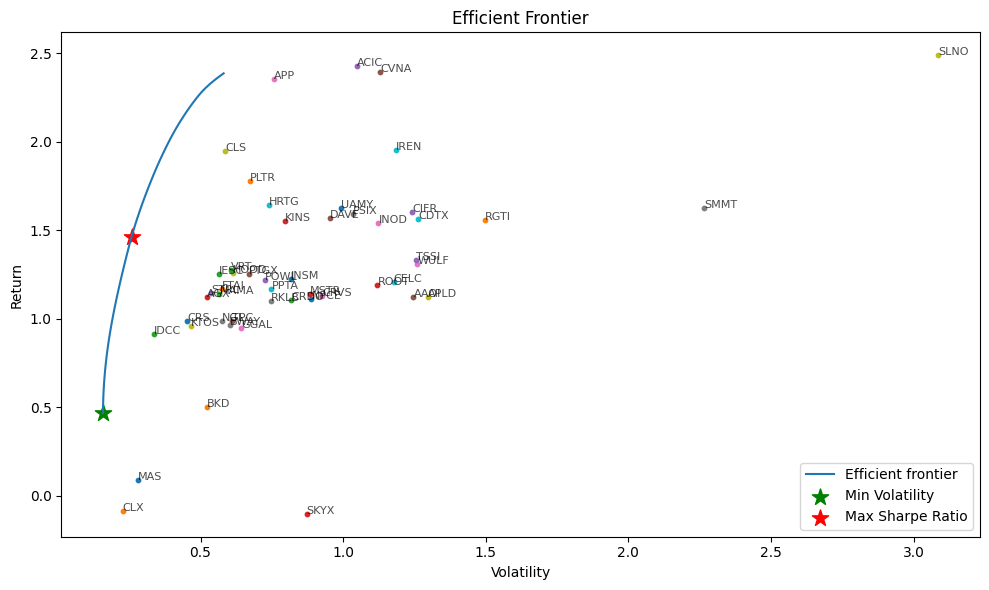


--- 최소 변동성 포트폴리오 ---
기대수익률: 46.73%, 변동성(리스크): 15.83%

--- 최대 샤프 지수 포트폴리오 ---
기대수익률: 146.36%, 변동성(리스크): 25.85%


In [6]:

# 'mu'와 'S'는 이미 계산되었다고 가정합니다.
if 'mu' in locals() and 'S' in locals():
    
    # 1. 최소 변동성 포트폴리오 계산
    # 객체를 새로 생성합니다.
    ef_min_vol = EfficientFrontier(mu, S)
    min_vol_weights = ef_min_vol.min_volatility()
    min_vol_ret, min_vol_risk, _ = ef_min_vol.portfolio_performance()
    
    # 2. 최대 샤프 지수 포트폴리오 계산
    # 객체를 다시 새로 생성합니다.
    # SGOV 수익률 3.8%를 무위험 수익률로 설정
    ef_max_sharpe = EfficientFrontier(mu, S)
    max_sharpe_weights = ef_max_sharpe.max_sharpe(risk_free_rate=0.038)
    max_sharpe_ret, max_sharpe_risk, _ = ef_max_sharpe.portfolio_performance(risk_free_rate=0.038)

    # 3. 시각화 (효율적 투자선은 한 번만 계산)
    ef_for_plotting = EfficientFrontier(mu, S)
    fig, ax = plt.subplots(figsize=(10, 6))
    plotting.plot_efficient_frontier(ef_for_plotting, ax=ax, show_assets=False)
    
    # 계산된 포트폴리오 결과 플로팅
    ax.scatter(min_vol_risk, min_vol_ret, marker="*", color="g", s=150, label="Min Volatility")
    ax.scatter(max_sharpe_risk, max_sharpe_ret, marker="*", color="r", s=150, label="Max Sharpe Ratio")

    # # 각 포트폴리오의 티커별 위치 표시
    for ticker in tickers:
        ret = mu[ticker]
        risk = np.sqrt(S.loc[ticker, ticker])
        ax.scatter(risk, ret, marker="o", s=10)
        ax.text(risk, ret, ticker, fontsize=8, alpha=0.7)
    

    # 그래프 스타일 설정
    ax.set_title("Efficient Frontier")
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    print("\n--- 최소 변동성 포트폴리오 ---")
    print(f"기대수익률: {min_vol_ret:.2%}, 변동성(리스크): {min_vol_risk:.2%}")
    
    print("\n--- 최대 샤프 지수 포트폴리오 ---")
    print(f"기대수익률: {max_sharpe_ret:.2%}, 변동성(리스크): {max_sharpe_risk:.2%}")

In [7]:
def print_weights(weights):
    """가중치를 깔끔하게 출력하는 함수"""
    weights_series = pd.Series(weights)
    # 가중치가 0.1% 이상인 종목만 출력
    print(weights_series[weights_series > 0.001].sort_values(ascending=False).to_string())

if 'ef' in locals():
    # 리스크 범위를 정의합니다 (최소 변동성 ~ 최대 샤프 지수)
    min_risk_level = min_vol_risk
    max_risk_level = max_sharpe_risk
    risk_range = max_risk_level - min_risk_level
    
    # 목표 리스크 수준을 퍼센트로 정의
    target_risk_percentages = [0.60, 0.65, 0.70, 0.80, 0.90, 1.00]
    
    print("\n" + "="*50)
    print("           특정 리스크 수준별 포트폴리오 가중치")
    print("="*50 + "\n")
    
    for p in target_risk_percentages:
        # 목표 변동성(리스크) 값을 계산
        target_risk = min_risk_level + risk_range * p
        
        print(f"--- 리스크 수준: {p:.0%} (목표 변동성: {target_risk:.2%}) ---")
        
        try:
            # 해당 목표 리스크를 달성하는 포트폴리오를 계산
            ef_target_risk = EfficientFrontier(mu, S)

            target_weights = ef_target_risk.efficient_risk(target_volatility=target_risk)
            
            # 가중치 출력
            print_weights(target_weights)
            print("\n" + "-"*50 + "\n")
            
        except Exception as e:
            print(f"해당 리스크 수준의 포트폴리오를 계산할 수 없습니다: {e}\n")

In [8]:
import json # JSON 라이브러리 추가

def print_weights(weights):
    """가중치를 깔끔하게 출력하는 함수"""
    weights_series = pd.Series(weights)
    # 가중치가 0.1% 이상인 종목만 출력
    print(weights_series[weights_series > 0.001].sort_values(ascending=False).to_string())

if 'ef' in locals():
    # 리스크 범위를 정의합니다 (최소 변동성 ~ 최대 샤프 지수)
    min_risk_level = min_vol_risk
    max_risk_level = max_sharpe_risk
    risk_range = max_risk_level - min_risk_level
    
    # 목표 리스크 수준을 퍼센트로 정의
    target_risk_percentages = [0.60, 0.65, 0.70, 0.80, 0.90, 1.00]
    
    print("\n" + "="*50)
    print("           특정 리스크 수준별 포트폴리오 가중치")
    print("="*50 + "\n")
    
    for p in target_risk_percentages:
        # 목표 변동성(리스크) 값을 계산
        target_risk = min_risk_level + risk_range * p
        
        print(f"--- 리스크 수준: {p:.0%} (목표 변동성: {target_risk:.2%}) ---")
        
        try:
            # 해당 목표 리스크를 달성하는 포트폴리오를 계산
            ef_target_risk = EfficientFrontier(mu, S)

            target_weights = ef_target_risk.efficient_risk(target_volatility=target_risk)
            
            # 가중치 출력
            print_weights(target_weights)

            # 📌 추가된 부분: p가 0.65일 때 JSON 파일로 저장
            if p == 0.65:
                # 가중치가 0.1% 이상인 종목만 필터링하여 새로운 딕셔너리 생성
                weights_to_save = {ticker: weight for ticker, weight in target_weights.items() if weight > 0.001}
                
                output_json_filename = 'portfolio_weights_65_risk.json'
                with open(output_json_filename, 'w', encoding='utf-8') as f:
                    json.dump(weights_to_save, f, ensure_ascii=False, indent=4)
                
                print(f"\n  ✨ 65% 리스크 포트폴리오가 '{output_json_filename}' 파일로 저장되었습니다.")

            print("\n" + "-"*50 + "\n")
            
        except Exception as e:
            print(f"해당 리스크 수준의 포트폴리오를 계산할 수 없습니다: {e}\n")

In [9]:

# 맥스 샤프 비율 포트폴리오 가중치를 JSON 파일로 저장
if 'max_sharpe_weights' in locals():
    # 가중치가 0.1% 이상인 종목만 필터링
    filtered_weights = {ticker: weight for ticker, weight in max_sharpe_weights.items() if weight > 0.001}
    
    # JSON 파일로 저장
    output_json_filename = 'portfolio_weights_max_sharpe.json'
    with open(output_json_filename, 'w', encoding='utf-8') as f:
        json.dump(filtered_weights, f, ensure_ascii=False, indent=4)
    
    print(f"\n✅ 맥스 샤프 비율 포트폴리오 가중치가 '{output_json_filename}' 파일로 저장되었습니다.")
    print(f"   - 종목 수: {len(filtered_weights)}")
    print(f"   - 가중치 합계: {sum(filtered_weights.values()):.4f}")


✅ 맥스 샤프 비율 포트폴리오 가중치가 'portfolio_weights_max_sharpe.json' 파일로 저장되었습니다.
   - 종목 수: 22
   - 가중치 합계: 0.9994


In [10]:
input_filename = 'portfolio_weights_max_sharpe.json'
try:
    with open(input_filename, 'r', encoding='utf-8') as f:
        weights = json.load(f)
    
    # 현재 가중치 합계 계산
    current_sum = sum(weights.values())
    
    # 기존 가중치를 조정하여 총합이 0.6이 되도록 스케일링
    M_V = 0.7

    # 모든 가중치를 소수점 자리까지 반올림
    scaling_factor = 1-M_V / current_sum
    scaled_weights = {ticker: weight * scaling_factor for ticker, weight in weights.items()}
    rounded_weights = {ticker: round(weight, 3) for ticker, weight in scaled_weights.items()}

    # MONEY 티커 추가 (비중 0.4)
    scaled_weights['MONEY'] = M_V

    # 라운딩으로 인한 오차를 보정하여 정확히 합계가 1이 되도록 조정
    total_after_rounding = sum(rounded_weights.values())
    if total_after_rounding != 1.00:
        # 가장 큰 가중치를 가진 티커에 오차를 더하거나 빼서 합계를 1로 맞춤
        max_ticker = max(rounded_weights.items(), key=lambda x: x[1] if x[0] != 'MONEY' else 0)[0]
        rounded_weights[max_ticker] = round(rounded_weights[max_ticker] + (1.00 - total_after_rounding), 3)
    
    # 최종 포트폴리오 가중치를 JSON 파일로 저장
    output_filename = 'final_portfolio_weights.json'
    with open(output_filename, 'w', encoding='utf-8') as f:
        json.dump(rounded_weights, f, ensure_ascii=False, indent=4)
    
    print(f"\n✅ 최종 포트폴리오 가중치가 '{output_filename}' 파일로 저장되었습니다.")
    print(f"   - MONEY 비중: {rounded_weights.get('MONEY', 0):.3f}")
    print(f"   - 기타 자산 비중 총합: {sum(rounded_weights.values()) - rounded_weights.get('MONEY', 0):.3f}")
    print(f"   - 전체 비중 총합: {sum(rounded_weights.values()):.3f}")
    
except FileNotFoundError:
    print(f"❌ 오류: '{input_filename}' 파일을 찾을 수 없습니다. 이전 단계를 먼저 실행해주세요.")
except Exception as e:
    print(f"❌ 오류 발생: {str(e)}")


✅ 최종 포트폴리오 가중치가 'final_portfolio_weights.json' 파일로 저장되었습니다.
   - MONEY 비중: 0.000
   - 기타 자산 비중 총합: 1.000
   - 전체 비중 총합: 1.000


In [12]:
import json

# --- 설정 ---
# 1. 최대 샤프 지수 가중치가 저장된 JSON 파일 경로
max_sharpe_weights_path = r'final_portfolio_weights.json'
# 2. 최종 포트폴리오를 저장할 파일 경로 (선택 사항)
final_portfolio_path = r'final_portfolio_with_cash.json'

# 3. 고정할 현금(MONEY) 비중
CASH_WEIGHT = 0.7
# 4. 나머지 자산에 할당될 비중
EQUITY_WEIGHT = 1 - CASH_WEIGHT

# --- 로직 ---
# 기존 포트폴리오 가중치 로드
with open(max_sharpe_weights_path, 'r', encoding='utf-8') as f:
    original_weights = json.load(f)

# 새로운 가중치를 계산할 딕셔너리 생성
adjusted_weights = {}

# 각 자산의 가중치를 남은 비중(0.6)에 맞춰 재계산하고 소수점 3자리에서 반올림
for ticker, weight in original_weights.items():
    adjusted_weights[ticker] = round(weight * EQUITY_WEIGHT, 3)

# 소수점 3자리에서 0.000인 항목 제거
adjusted_weights = {k: v for k, v in adjusted_weights.items() if v != 0.000}

# 반올림 후 MONEY를 제외한 나머지의 합계 계산
equity_sum = sum(adjusted_weights.values())

# MONEY를 제외한 나머지의 합이 정확히 0.6이 되도록 조정
if equity_sum != EQUITY_WEIGHT:
    # 가장 큰 가중치를 가진 자산에 오차를 보정
    difference = round(EQUITY_WEIGHT - equity_sum, 3)
    max_ticker = max(adjusted_weights.items(), key=lambda x: x[1])[0]
    adjusted_weights[max_ticker] = round(adjusted_weights[max_ticker] + difference, 3)

# 현금 비중 추가
adjusted_weights['MONEY'] = CASH_WEIGHT

# --- 결과 확인 ---
print(f"✅ 현금 비중 {CASH_WEIGHT}를 적용하여 포트폴리오 가중치를 재조정했습니다.")
print("\n--- 최종 조정된 포트폴리오 가중치 ---")

# 보기 좋게 정렬하여 출력
for ticker, weight in sorted(adjusted_weights.items()):
    print(f"- {ticker:<6}: {weight:.3f}")

print("---------------------------------------")
# MONEY를 제외한 자산들의 합계와 전체 합계 검증
equity_total = sum(v for k, v in adjusted_weights.items() if k != 'MONEY')
total_weight = sum(adjusted_weights.values())
print(f"📊 MONEY 제외 총 가중치: {equity_total:.3f}")
print(f"📊 전체 가중치 합계: {total_weight:.3f}")


# --- 파일 저장 (필요시 주석 해제) ---
with open(final_portfolio_path, 'w', encoding='utf-8') as f:
    json.dump(adjusted_weights, f, indent=4)
print(f"\n✅ 조정된 포트폴리오를 '{final_portfolio_path}' 파일에 저장했습니다.")


✅ 현금 비중 0.7를 적용하여 포트폴리오 가중치를 재조정했습니다.

--- 최종 조정된 포트폴리오 가중치 ---
- ACIC  : 0.006
- AGX   : 0.002
- APP   : 0.007
- BWAY  : 0.002
- CDTX  : 0.002
- CELC  : 0.001
- CLS   : 0.010
- CVNA  : 0.002
- HRTG  : 0.005
- IDCC  : 0.222
- INSM  : 0.004
- KINS  : 0.005
- KTOS  : 0.001
- MAMA  : 0.007
- MONEY : 0.700
- NGL   : 0.008
- NPCE  : 0.002
- PPTA  : 0.002
- PSIX  : 0.002
- PTGX  : 0.008
- SLNO  : 0.001
- UAMY  : 0.001
---------------------------------------
📊 MONEY 제외 총 가중치: 0.300
📊 전체 가중치 합계: 1.000

✅ 조정된 포트폴리오를 'final_portfolio_with_cash.json' 파일에 저장했습니다.
